# Generate random sampling of data

In [116]:
import numpy as np
np.set_printoptions(threshold='nan')
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
import fnmatch
from sklearn.cluster import KMeans,DBSCAN


"""
============ Start ============

You will be prompted to choose a file. Choose the output file of the quarter you are interested
in that was generated by keplerml.py. This may or may not have the .pkl extension.
"""

print("Choose .pkl output file.")

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
output = askopenfilename() # locate the pickle file with the relevant data
print(output.replace(os.path.dirname(output)+"/",""))

if output:
    print("Importing data...")
    pathtofile = os.path.dirname(output)
    outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
    outputdata = []
    # Switched methods of saving data in keplerml.py, the following handles files saved 
    while True:
        try:
            o = pickle.load(outputfile)
        except EOFError:
            break
        else:
            outputdata.append(o)
    outputfile.close()
        
    # Update to keplerml.py saves the output more compactly, following accounts for that
    if len(outputdata)==1:
        outputdata = outputdata[0]
    
    files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()]
    
    NumLCs = 4000
    print("Choosing %s random files..."%NumLCs)
    randomInds = np.random.choice(range(len(files)), NumLCs, replace=False)

    # test if Tabby star is included in the otherwise random set, insert if not
    print("Checking for Tabby...")
    tabby = fnmatch.filter(files,'*8462852*')
    tabbyInd = files.index(tabby[0])
    npfiles = np.array(files)
    tabbyCheck = fnmatch.filter(npfiles[randomInds], tabby[0])
    
    if tabbyCheck==[]:
        print("Adding Tabby...")
        randomInds = np.delete(randomInds,0)
        randomInds = np.insert(randomInds,0,tabbyInd)
    
    filesSample = npfiles[randomInds]
    dataSample = [outputdata[i][1:] for i in randomInds]
    
    rand_lcs = map(lambda f: f[4:13], filesSample)

    idout = open('50k_rand_filelist','w')
    pickle.dump(rand_lcs,idout)
    idout.close()
    print("Done.")

Choose .pkl output file.
Q4_output
Importing data...
Choosing 50000 random files...
Checking for Tabby...
Adding Tabby...
Done.


In [124]:
import numpy as np
np.set_printoptions(threshold='nan')
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
import fnmatch
from sklearn.cluster import KMeans,DBSCAN
from multiprocessing import Pool
from numbapro import cuda

"""
============ Start ============

You will be prompted to choose a file. Choose the output file of the quarter you are interested
in that was generated by keplerml.py. This may or may not have the .pkl extension.
"""

def matchfile(filearray):
    lc = filearray[0]
    files = filearray[1]
    if fnmatch.filter(files,"*"+lc+"*")!=[]:
        return fnmatch.filter(files,"*"+lc+"*")[0] 
    return
    
@cuda.autojit
def cu_matchfile(lcs,files,rand_files_inds):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    
    lc = lcs[i]
    
    if i<=len(rand_files_inds):
        for ind,f in enumerate(files):
            if lc == f:
                rand_files_inds[i] = ind
                return


print("Choose .pkl output file.")

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
output = askopenfilename() # locate the pickle file with the relevant data
print(output.replace(os.path.dirname(output)+"/",""))

if output:
    print("Importing data...")
    pathtofile = os.path.dirname(output)
    outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
    outputdata = []
    # Switched methods of saving data in keplerml.py, the following handles files saved 
    while True:
        try:
            o = pickle.load(outputfile)
        except EOFError:
            break
        else:
            outputdata.append(o)
    outputfile.close()
        
    # Update to keplerml.py saves the output more compactly, following accounts for that
    if len(outputdata)==1:
        outputdata = outputdata[0]
    print("Data Loaded")
    
    files = [outputdata[i][0] for i in range(len(outputdata)) \
             if not np.isnan(outputdata[i][1:]).any() \
             and not np.isinf(outputdata[i][1:]).any()]
    
    filesIDs = np.array(map(lambda f: int(f[4:13]), files))
                     
    idfl = open('50k_rand_filelist','r+')
    rand_lcs = pickle.load(idfl)
    idfl.close()
    rand_lcs_as_int = np.array(map(lambda x: int(x), rand_lcs))

    device = cuda.get_current_device()
    
    N=len(rand_lcs)

    drand_lcs = cuda.to_device(rand_lcs_as_int)
    dfiles = cuda.to_device(filesIDs)
    
    rand_inds = np.array([-1 for i in rand_lcs_as_int])
    drand_inds = cuda.to_device(rand_inds)
    
    # Set up enough threads for kernel
    tpb = device.WARP_SIZE
    bpg = int(np.ceil(float(N)/tpb))
    
    cu_matchfile[bpg,tpb](drand_lcs,dfiles,drand_inds)
    
    filesSample_inds = drand_inds.copy_to_host()
    filesSample_inds = [int(ind) for ind in fileSample_inds if ind!=-1]
    
    filesSample = [files[ind] for ind in filesSample_inds]
    dataSample = np.array([outputdata[i][1:] for ind in filesSample_inds])
    
    print("Done.")

Choose .pkl output file.
Q8_output
Importing data...
Data Loaded
Done.


## Apply t-SNE dimensionallity reduction and Plot for review

### TSNE with perplexity varied, init='pca'

[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4801 nearest neighbors...
[t-SNE] Computing 9999 nearest neighbors...
[t-SNE] Computing 3601 nearest neighbors...
[t-SNE] Computing 8401 nearest neighbors...
[t-SNE] Computing 7201 nearest neighbors...
[t-SNE] Computing 9601 nearest neighbors...
[t-SNE] Computing 6001 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Co

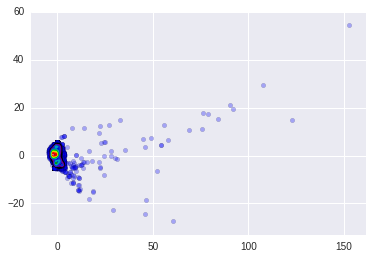

In [6]:
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import os
from multiprocessing import Pool
%matplotlib inline

np.save('X_tmp.npy',dataSample)
np.save('files_tmp.npy',filesSample)

def tsne_fit(perplexity):
    
    # Import some things
    X = np.load('X_tmp.npy')
    filesSample = np.load('files_tmp.npy')
    
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    tsne = TSNE(n_components=2,perplexity=perplexity,init='pca',verbose=True)
    tsne_fit=tsne.fit_transform(X)
    
    # Goal is to minimize the KL-Divergence
    kl_div = tsne.kl_divergence_ 
    
    # Tying files to t-SNE data coordinates
    dataTSNE = [[filesSample[i],tsne_fit[i][0],tsne_fit[i][1]] for i in range(len(tsne_fit))]
    
    return kl_div,tsne_fit,dataTSNE

perplexities = np.array([1200,1600,2000,2400,2800,3200,len(filesSample)/3])
p = Pool(len(perplexities))
tsne = p.map(tsne_fit,perplexities)
p.close()

i=min(enumerate(tsne), key=lambda t:t[1][1])[0]

print("Optimal perplexity was %s"%perplexities[ind])
print("Minimum KL-Divergence was %s"%min_kl_div)

tsne_min_kl = tsne[ind]
tsne_fit = tsne_min_kl[1]
x=tsne_fit[:,0]
y=tsne_fit[:,1]
dataTSNE = tsne_min_kl[2]

os.remove('X_tmp.npy')
os.remove('files_tmp.npy')

with sns.axes_style("darkgrid"):
    sns.kdeplot(x, y,shade=False,cmap="nipy_spectral")
    plt.scatter(x, y,alpha=.3)

## Save the t-SNE sample output

In [99]:
# Current convention is to save in the following format:
# Quarter_Init_Perplexity
# Example, Quarter 4 initialized with 'pca' with an optimal perplexity of 1200:
# Q4_pca_1200

def file_save(data):
    f = asksaveasfile(mode='w', defaultextension=".pkl")
    if f is None: # asksaveasfile return `None` if dialog closed with "cancel".
        print("Cancelled.")
        return
    pickle.dump(data,f)
    f.close()

file_save(dataTSNE)

# Cluster the Data

In [1]:
""" 
Creates clusters from processed data for any number of dimensions using k-means or DBSCAN.

Requirement: Processed lightcurve data in a .pkl file. Elements in .pkl file should be
arranged as follows:
[str(filename),feature1,feature2,...,featureN]
"""
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
from sklearn.cluster import DBSCAN, KMeans
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
from numbapro import cuda
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory, asksaveasfile
import fnmatch
import csv

root = Tk.Tk()
def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def loadData(filename):
    pathtofile = os.path.dirname(filename)
    f = open(filename,'r+') # show an "Open" dialog box and return the path to the selected file
    data = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        else:
            data.append(o)
    f.close()
    
    if len(data) == 1:
        data = data[0]
        
    return data
"""
DBSCAN Clustering
"""

from sklearn.neighbors import NearestNeighbors



def eps_est(data):
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    distArr = distances[:,3]
    distArr.sort()
    pts = [i for i in range(len(distArr))]

    # The following looks for the first instance (past the mid point) where the mean of the following 50 points
    # is at least 5% greater than the mean of the previous 50 points.
    # Alternatively, perhaps a better method, we could consider the variance of the points and draw conclusions from that
    number = 50
    cutoff = 1.05
    for i in range(number,len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]) and i>(len(pts)%2+len(pts))/2:
            print("Epsilon is in the neighborhood of %s"%distArr[i])
            dbEps = distArr[i]
            break
    return dbEps

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    
    return clusters, coreSampleIndices

def DBSCAN_cluster(files,data):
    dbEps = eps_est(data)
    neighbors = 20
    params = [dbEps,neighbors]
    print("Clustering data with DBSCAN...")
    clusterLabels,coreSampleIndices = DBSCAN_clusters(data,dbEps*2,neighbors)
    plotArray = [files,clusterLabels,data]
    print("Sorting...")
    centerIndex=coreSampleIndices[0]
    outlierIndices = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
    outlierFiles = [files[i] for i in outlierIndices]
    numout = len(outlierFiles)
    numclusters = max(clusterLabels+1)
    tabbyInd = np.where(files==fnmatch.filter(files,'*8462852*')[0])[0][0]
    print(data[tabbyInd][0],data[tabbyInd][1])
    if fnmatch.filter(files,'*8462852*')[0] in outlierFiles:
        print("Tabby has been found to be an outlier in DBSCAN.")
    else:
        print("Tabby has not been found to be an outlier in DBSCAN")
        
    print("There were %s clusters and %s total outliers"%(numclusters,numout))
    return clusterLabels,coreSampleIndices, params



"""
K-means Clustering
"""

def KMeans_clusters(data,nclusters):
    # Run KMeans, get clusters
    npdata = np.array(data)
    est = KMeans(n_clusters=nclusters)
    est.fit(npdata)
    clusters = est.labels_
    centers = est.cluster_centers_
    return clusters, centers

def seperatedClusters(data,nclusters,clusters):
    """
    Args:
    data - all data, organized by lightcurve 
    nclusters - number of clusters
    clusters - cluster labels
    
    Purpose: Create arrays dataByCluster and clusterIndexes containing data seperated by
    by cluster.
    """
    dataByCluster = []
    clusterIndexes = []
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
        # Keeping track of which points get pulled into each cluster:
        clusterIndexes.append([j[0] for j in enumerate(data) if clusters[j[0]]==i])
        
        # Separating the clusters out into their own arrays (w/in the cluster array)
        dataByCluster.append([data[clusterIndexes[i][j]] for j in range(len(clusterIndexes[i]))])
        
    return dataByCluster, clusterIndexes

def outliers(data,clusters,centers,files):
    """
    Args:
    data - all the data
    clusters - the cluster labels from kmeans. DBSCAN will require different methodology
    centers - locations of the cluster centers
    
    Purpose:
    Separate out the data on the edge of the clusters which are the most likely anomalous data.
    """
    
    nclusters = len(centers)
    
    """
    Initializing arrays
    """
    
    cluster, clusterIndexes = seperatedClusters(data,nclusters,clusters)
    clusterIndexes = np.array(clusterIndexes)
    twoSigma = [] #probably doesn't need an array 
    distFromCenter = []
    allTypical=[]
    allOutliers=[]
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
        """
        ========== Finding points outside of the cutoff ===========
        """
        # not currently using this cutoff.
        sigma = np.std(cluster[i])
        twoSigma.append(2*sigma)
        
        """
            ==== Calculating distances to each point ====
        """
        centerx = np.mean(data[clusters==i][:,0])
        # Calculate distances to each point in each cluster to the center of its cluster
        distFromCenter.append([sum((pt-centers[i])**2)**.5 for pt in cluster[i]])
        
        """
            ==== Finding outliers and the standard (defined by the closest to the center) ====
        """
        cutoff=.5*max(distFromCenter[i])
        # Will implement a better cutoff.
        cutoff = 2*sigma
        # returns cluster indices of the outliers and the typical lcs
        outliers=[j[0] for j in enumerate(distFromCenter[i]) if j[1]>=cutoff]
        typical = [j[0] for j in enumerate(distFromCenter[i]) if j[1]==min(distFromCenter[i])]
        
        # Add typical lightcurve to list. Only 1 produced at present, but this may change. The following
        # accounts for adding more typical lcs later.
        clusterIndexes[i] = np.array(clusterIndexes[i])
        allTypical.append(clusterIndexes[i][typical])
            
        # place outliers from this cluster into general outlier list
        allOutliers.append(clusterIndexes[i][outliers])
        
    return allOutliers,allTypical

"""
============ Start ============
"""
        
"""--- Importing the relevant data ---"""
clusterType = raw_input('Which clustering method (kmeans or dbscan)? ')
if clusterType == 'KMeans' or clusterType == 'kmeans' or clusterType == 'Kmeans': 
    Tk.Tk.withdraw(root) # we don't want a full GUI, so keep the root window from appearing
    output = askopenfilename() # locate the pickle file with the relevant data
    print output
    if output:
        saveas = asksaveasfile(mode='wb',defaultextension='.csv')
        outputdata = np.array(loadData(output))

        files = outputdata[:,0]
        data = np.array(outputdata[:,1:].astype(float))

        # nclusters can be obtained through the optimalK.py script 
        #nclusters = int(raw_input('Enter the number of clusters expected: '))
        nclusters = 1
        clusterLabels,centers=KMeans_clusters(data,nclusters)
        dataByCluster,clusterIndexes = seperatedClusters(data,nclusters,clusterLabels)
        outlierInds,typical=outliers(data,clusterLabels,centers,files)
        numout = sum([len(i[1]) for i in enumerate(outlierInds)])
        tabbyInd = np.where(files==fnmatch.filter(files,'*8462852*')[0])[0][0]
        for i in range(len(outlierInds)):
            if tabbyInd in outlierInds[i]:
                print("Tabby has been found to be an outlier in k-means.")
                break
            if i == len(outlierInds)-1:
                print("Tabby has not been found to be an outlier in k-means")
            
        print("There were %s outliers in %s clusters"%(numout,nclusters))
        
        clusterLabels = clusterLabels+1
        
        for i in typical:
            clusterLabels[i] = 0
        nclusters = max(clusterLabels)
        outlierfiles=[]
        for i in outlierInds:
            clusterLabels[i] = -1
            outlierfiles.append(files[i])
        plotArray = [files,clusterLabels,data]
        print("Done.")
        if saveas:
            info = ["%s,%s,%s"%(files[i],clusterLabels[i],",".join(map(str,data[i]))) for i in range(len(files))]
            writer = csv.writer(saveas)
            writer.writerows(info)
            saveas.close()
        #info = ["%s,%s,%s"%(files[i],clusterLabels[i],",".join(map(str,data[i]))) for i in range(len(files))]
        #info = [[files[i],clusterLabels[i]].append(data[i]) for i in range(len(files))]
        
elif clusterType == 'DBSCAN' or clusterType =='dbscan':
    
    Tk.Tk.withdraw(root) # we don't want a full GUI, so keep the root window from appearing
    output = askopenfilename() # locate the pickle file with the relevant data
    if output:
        saveas = asksaveasfile(mode='wb',defaultextension='.csv')
        print("Loading file...")
        outputdata = np.array(loadData(output))

        files = outputdata[:,0]
        data = np.array(outputdata[:,1:].astype(float))
        
        print("Clustering data...")
        clusterLabels,coreSampleIndices,params = DBSCAN_cluster(files,data)
        plotArray = [files,clusterLabels,data]
        print("Sorting...")
        centerIndex=coreSampleIndices[0]
        outlierIndices = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
        outlierfiles = [files[i] for i in outlierIndices]
        print("Done.")
        if saveas:
            outlierIDs = [lc[4:13] for lc in outlierfiles]
            info = [outlierIDs,['Number of outliers',len(outlierfiles)],['Number of clusters',max(clusterLabels)+1]\
                    ,['epsilon',params[0]],['Neighbors',params[1]]]
            writer = csv.writer(saveas)
            writer.writerows(info)
            saveas.close()
else:
    print("Only KMeans and DBSCAN are compatible with this program at this time.")
    sys.exit()


numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.


Which clustering method (kmeans or dbscan)? kmeans
/home/dgiles/Documents/KeplerLCs/output/TSNE_Reductions/Q4_pca_1600.pkl
Tabby has not been found to be an outlier in k-means
There were 52 outliers in 1 clusters
Done.


# Plot clusters (must be generated above)

In [125]:
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.figure import Figure
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory
from numbapro import cuda

root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = plotArray[0]
    clusterLabels = plotArray[1]
    cNorm  = colors.Normalize(vmin=0, vmax=max(clusterLabels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
    # data is an array containing each data point
    data = plotArray[2]
    # tsneX has all the x-coordinates
    tsneX = data[:,0]
    # tsneY has all the y-coordinates
    tsneY = data[:,1]   
    outX = []
    outY = []
    files_out = []
    clusterX = []
    clusterY = []
    files_cluster = []
    
    for i in enumerate(data):
        if clusterLabels[i[0]] == -1:
            outX.append(i[1][0])
            outY.append(i[1][1])
            files_out.append(files[i[0]])
        else:
            clusterX.append(i[1][0])
            clusterY.append(i[1][1])
            files_cluster.append(files[i[0]])
    
    filesWpath = [pathtofits+files[i] for i in range(len(files))]
    numcpus = cpu_count()
    usecpus = numcpus*4
    p = Pool(usecpus)
    lc = p.map(read_kepler_curve,filesWpath)
    p.close()
    p.join()
    t=[lc[i][0] for i in range(len(lc))]
    nf=[lc[i][1] for i in range(len(lc))]
    del(lc)
    lightcurveData=np.array([t,nf])
    del(t)
    del(nf)
    del(numcpus)
    del(usecpus)
    del(filesWpath)
    """--- Organizing data and Labels ---"""

    tabbyInd = np.argwhere(files==fnmatch.filter(files,'*8462852*')[0])[0][0]
    
    fig = Figure()
    
    # a tk.DrawingArea
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    toolbar = NavigationToolbar2TkAgg(canvas, root)
    toolbar.update()
    canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    # empty subplot for scattered data
    ax = fig.add_subplot(211)
    
    # empty subplot for lightcurves
    ax2 = fig.add_subplot(212)
    
    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (2,), "distance: point.shape is wrong: %s, must be (2,)" % point.shape
        x2,y2 = ax.transData.transform((point[0],point[1]))

        return np.sqrt ((x2 - event.x)**2 + (y2 - event.y)**2)
    
    def calcClosestDatapoint(XT, event):
        """"Calculate which data point is closest to the mouse position.
        
        Args:
            XT (np.array) - array of points, of shape (numPoints, 2)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (XT[:,i], event) for i in range(XT.shape[1])]
        
        return np.argmin(distances)
    
    def drawData(X, index):
        # Plots the lightcurve of the point chosen
        ax2.cla()
        
        x=X[0][index]
        y=X[1][index]
        
        axrange=0.55*(max(y)-min(y))
        mid=(max(y)+min(y))/2
        yaxmin = mid-axrange
        yaxmax = mid+axrange
        ax2.set_ylim(yaxmin,yaxmax)
        ax2.set_xlabel('Time (Days)',fontsize=18)
        ax2.set_ylabel(r'$\frac{\Delta F}{F}$',fontsize=18)
        ax2.plot(x, y, 'o',markeredgecolor='none', c=scalarMap.to_rgba(clusterLabels[index]), alpha=0.2)
        ax2.plot(x, y, '-',markeredgecolor='none', c=scalarMap.to_rgba(clusterLabels[index]), alpha=0.7)
        ax2.set_title(files[index],fontsize = 18)
        canvas.draw()
        
    def annotatePt(XT, index):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        x2, y2 = XT[index][0], XT[index][1]
        # Either update the position, or create the annotation
        if hasattr(annotatePt, 'label'):
            annotatePt.label.remove()
        # Get data point from array of points X, at position index
        annotatePt.label = ax.annotate( "%s" % files[index],
            xy = (x2, y2), xytext = (200, 40), textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'g', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
        canvas.draw()
    
    
    def onMouseClick(event, X):
        """Event that is triggered when mouse is clicked. Shows lightcurve for data point closest to mouse."""
        XT = np.array(reorganizeArray(X)) # array organized by feature, each in it's own array
        closestIndex = calcClosestDatapoint(XT, event)
        drawData(lightcurveData, closestIndex)
        
    def onMouseRelease(event, X):
        XT = np.array(reorganizeArray(X))
        closestIndex = calcClosestDatapoint(XT, event)
        annotatePt(X,closestIndex)
        #for centerIndex in centerIndices:
        #    annotateCenter(XT,centerIndex)
    
    def connect(X):
        """
        TODO: Limit it to being connected only when in axes.
        ISSUE: Double connects when replotted. Doesn't seem to want to disconnect.
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
            connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
            connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))
        """
        if hasattr(connect,'cidpress'):
            fig.canvas.mpl_disconnect(connect.cidpress)
        if hasattr(connect,'cidrelease'):
            fig.canvas.mpl_disconnect(connect.cidrelease)
        connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
        connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))

    def disconnect(event):
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
    
    def redraw():       
        # Clear the existing plots
        ax.cla()
        ax2.cla()        
        # Set those labels
        ax.set_xlabel("T-SNE X",fontsize=18)
        ax.set_ylabel("T-SNE Y",fontsize=18)
        # Scatter the data
        ax.scatter(tsneX, tsneY,c=clusterLabels,cmap='jet')
        ax.hexbin(tsneX,tsneY,mincnt=5,bins="log",cmap="inferno",gridsize=500)
        annotatePt(data,tabbyInd)
        drawData(lightcurveData,tabbyInd)
        #for centerIndex in centerIndices:
        #    annotateCenter(currentData1,centerIndex)
        
        if hasattr(redraw,'cidenter'):
                fig.canvas.mpl_disconnect(redraw.cidenter)
                fig.canvas.mpl_disconnect(redraw.cidexit)
        connect(data)
        #cidenter = fig.canvas.mpl_connect('axes_enter_event', lambda event: connect(event,currentData))
        #cidexit = fig.canvas.mpl_connect('axes_leave_event', lambda event: disconnect(event))
        canvas.draw()

    redraw() # First draw
    Tk.Tk.deiconify(root)
    canvas.show()
    
    def quit():
        root.quit()
        root.destroy()
        
    Tk.Button(root, text="Quit", command=quit).pack()
    
root.mainloop()

Choose the directory that the fits files are contained in.


<IPython.core.display.Javascript object>


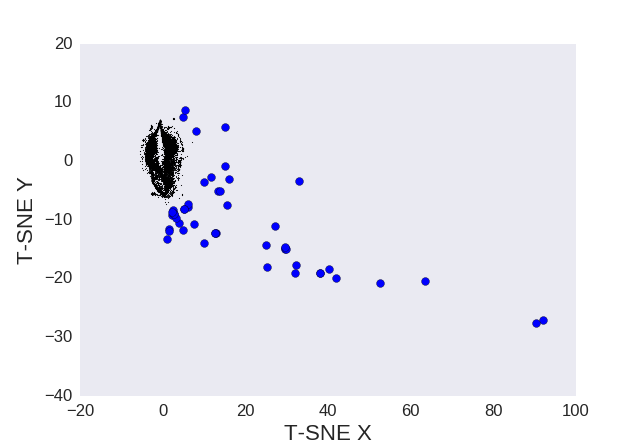

In [214]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
%matplotlib notebook
sns.set_style("dark")

if __name__ == '__main__':

    files = plotArray[0]
    clusterLabels = plotArray[1]
    cNorm  = colors.Normalize(vmin=0, vmax=max(clusterLabels))

    # data is an array containing each data point
    data = plotArray[2]

    outX = []
    outY = []
    files_out = []
    clusterX = []
    clusterY = []
    files_cluster = []
    
    for i in enumerate(data):
        if clusterLabels[i[0]] == -1:
            outX.append(i[1][0])
            outY.append(i[1][1])
            files_out.append(files[i[0]])
        else:
            clusterX.append(i[1][0])
            clusterY.append(i[1][1])
            files_cluster.append(files[i[0]])
        
    """--- Organizing data and Labels ---"""
    
    fig = plt.figure()

    xmid = (max(clusterX)+min(clusterX))/2
    xrng = (max(clusterX)-min(clusterX))/2
    
    #plt.xlim(xmid-xrng*1.05,xmid+xrng*1.05)
    
    ymid = (max(clusterY)+min(clusterY))/2
    yrng = (max(clusterY)-min(clusterY))/2
    
    #plt.ylim(ymid-yrng*1.05,ymid+yrng*1.05)
    
    plt.xlim(-20,100)
    plt.ylim(-40,20)
    
    # Set those labels
    plt.xlabel("T-SNE X",fontsize=20)
    plt.ylabel("T-SNE Y",fontsize=20)

    # Scatter the data
    plt.scatter(outX, outY,s=50)
    #plt.hexbin(clusterX,clusterY,mincnt=1,bins="log",cmap="inferno",gridsize=35)
    #plt.colorbar()
    plt.scatter(clusterX,clusterY,s=.5,c="black")
fig.show()

<IPython.core.display.Javascript object>


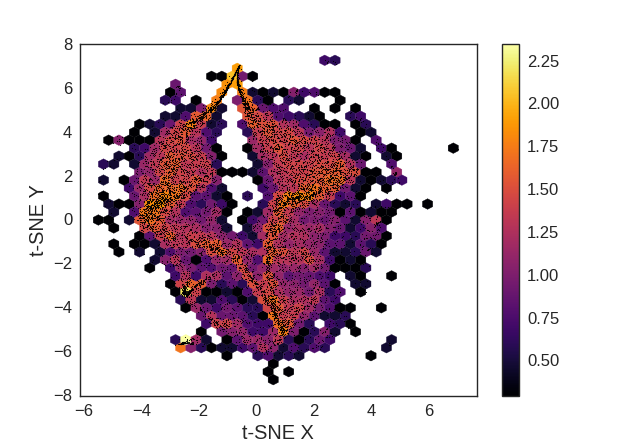

<IPython.core.display.Javascript object>


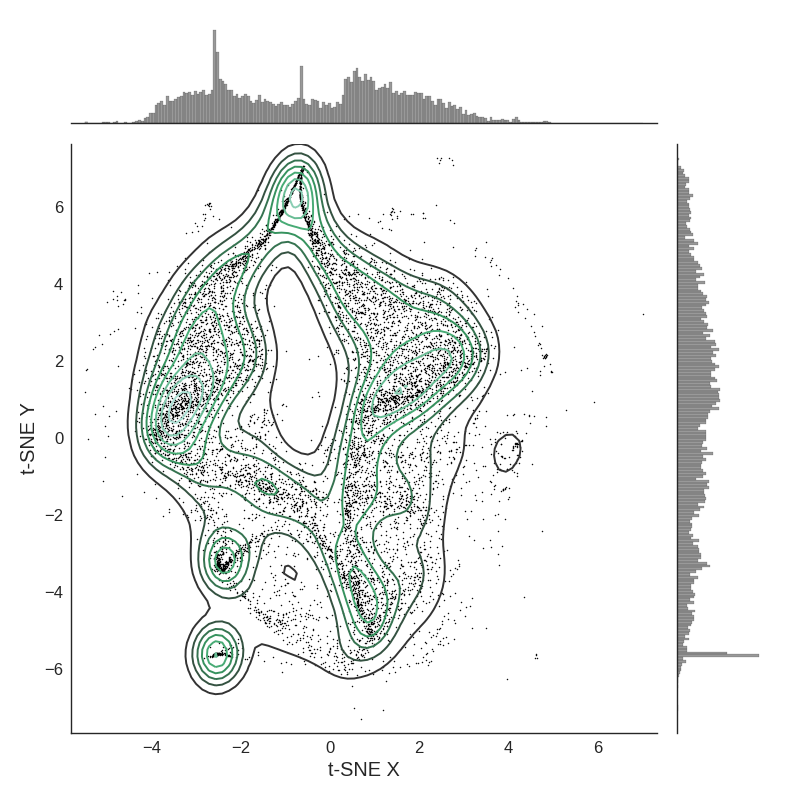

In [192]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df['t-SNE_X'] = clusterX
df['t-SNE_Y'] = clusterY
with sns.axes_style("white"):

    plt.xlabel("t-SNE X",fontsize=18)
    plt.ylabel("t-SNE Y",fontsize=18)
    plt.hexbin(clusterX,clusterY,mincnt=1,bins="log",cmap="inferno",gridsize=35)
    plt.colorbar()
    plt.scatter(clusterX,clusterY,s=.5,c='black')
    
    xmid = (max(clusterX)+min(clusterX))/2
    xrng = (max(clusterX)-min(clusterX))/2
    ymid = (max(clusterY)+min(clusterY))/2
    yrng = (max(clusterY)-min(clusterY))/2

    g = sns.jointplot(x="t-SNE_X",y="t-SNE_Y",data=df,kind='scatter',color="black",stat_func=None,size=10,\
                      xlim=(xmid-xrng*1.05,xmid+xrng*1.05),ylim=(ymid-yrng*1.05,ymid+yrng*1.05),\
                      marginal_kws=dict(bins=200),\
                      joint_kws=dict(s=1)).plot_joint(sns.kdeplot)
    g.set_axis_labels("t-SNE X","t-SNE Y", fontsize=18)



Choose the directory that the fits files are contained in.


<IPython.core.display.Javascript object>


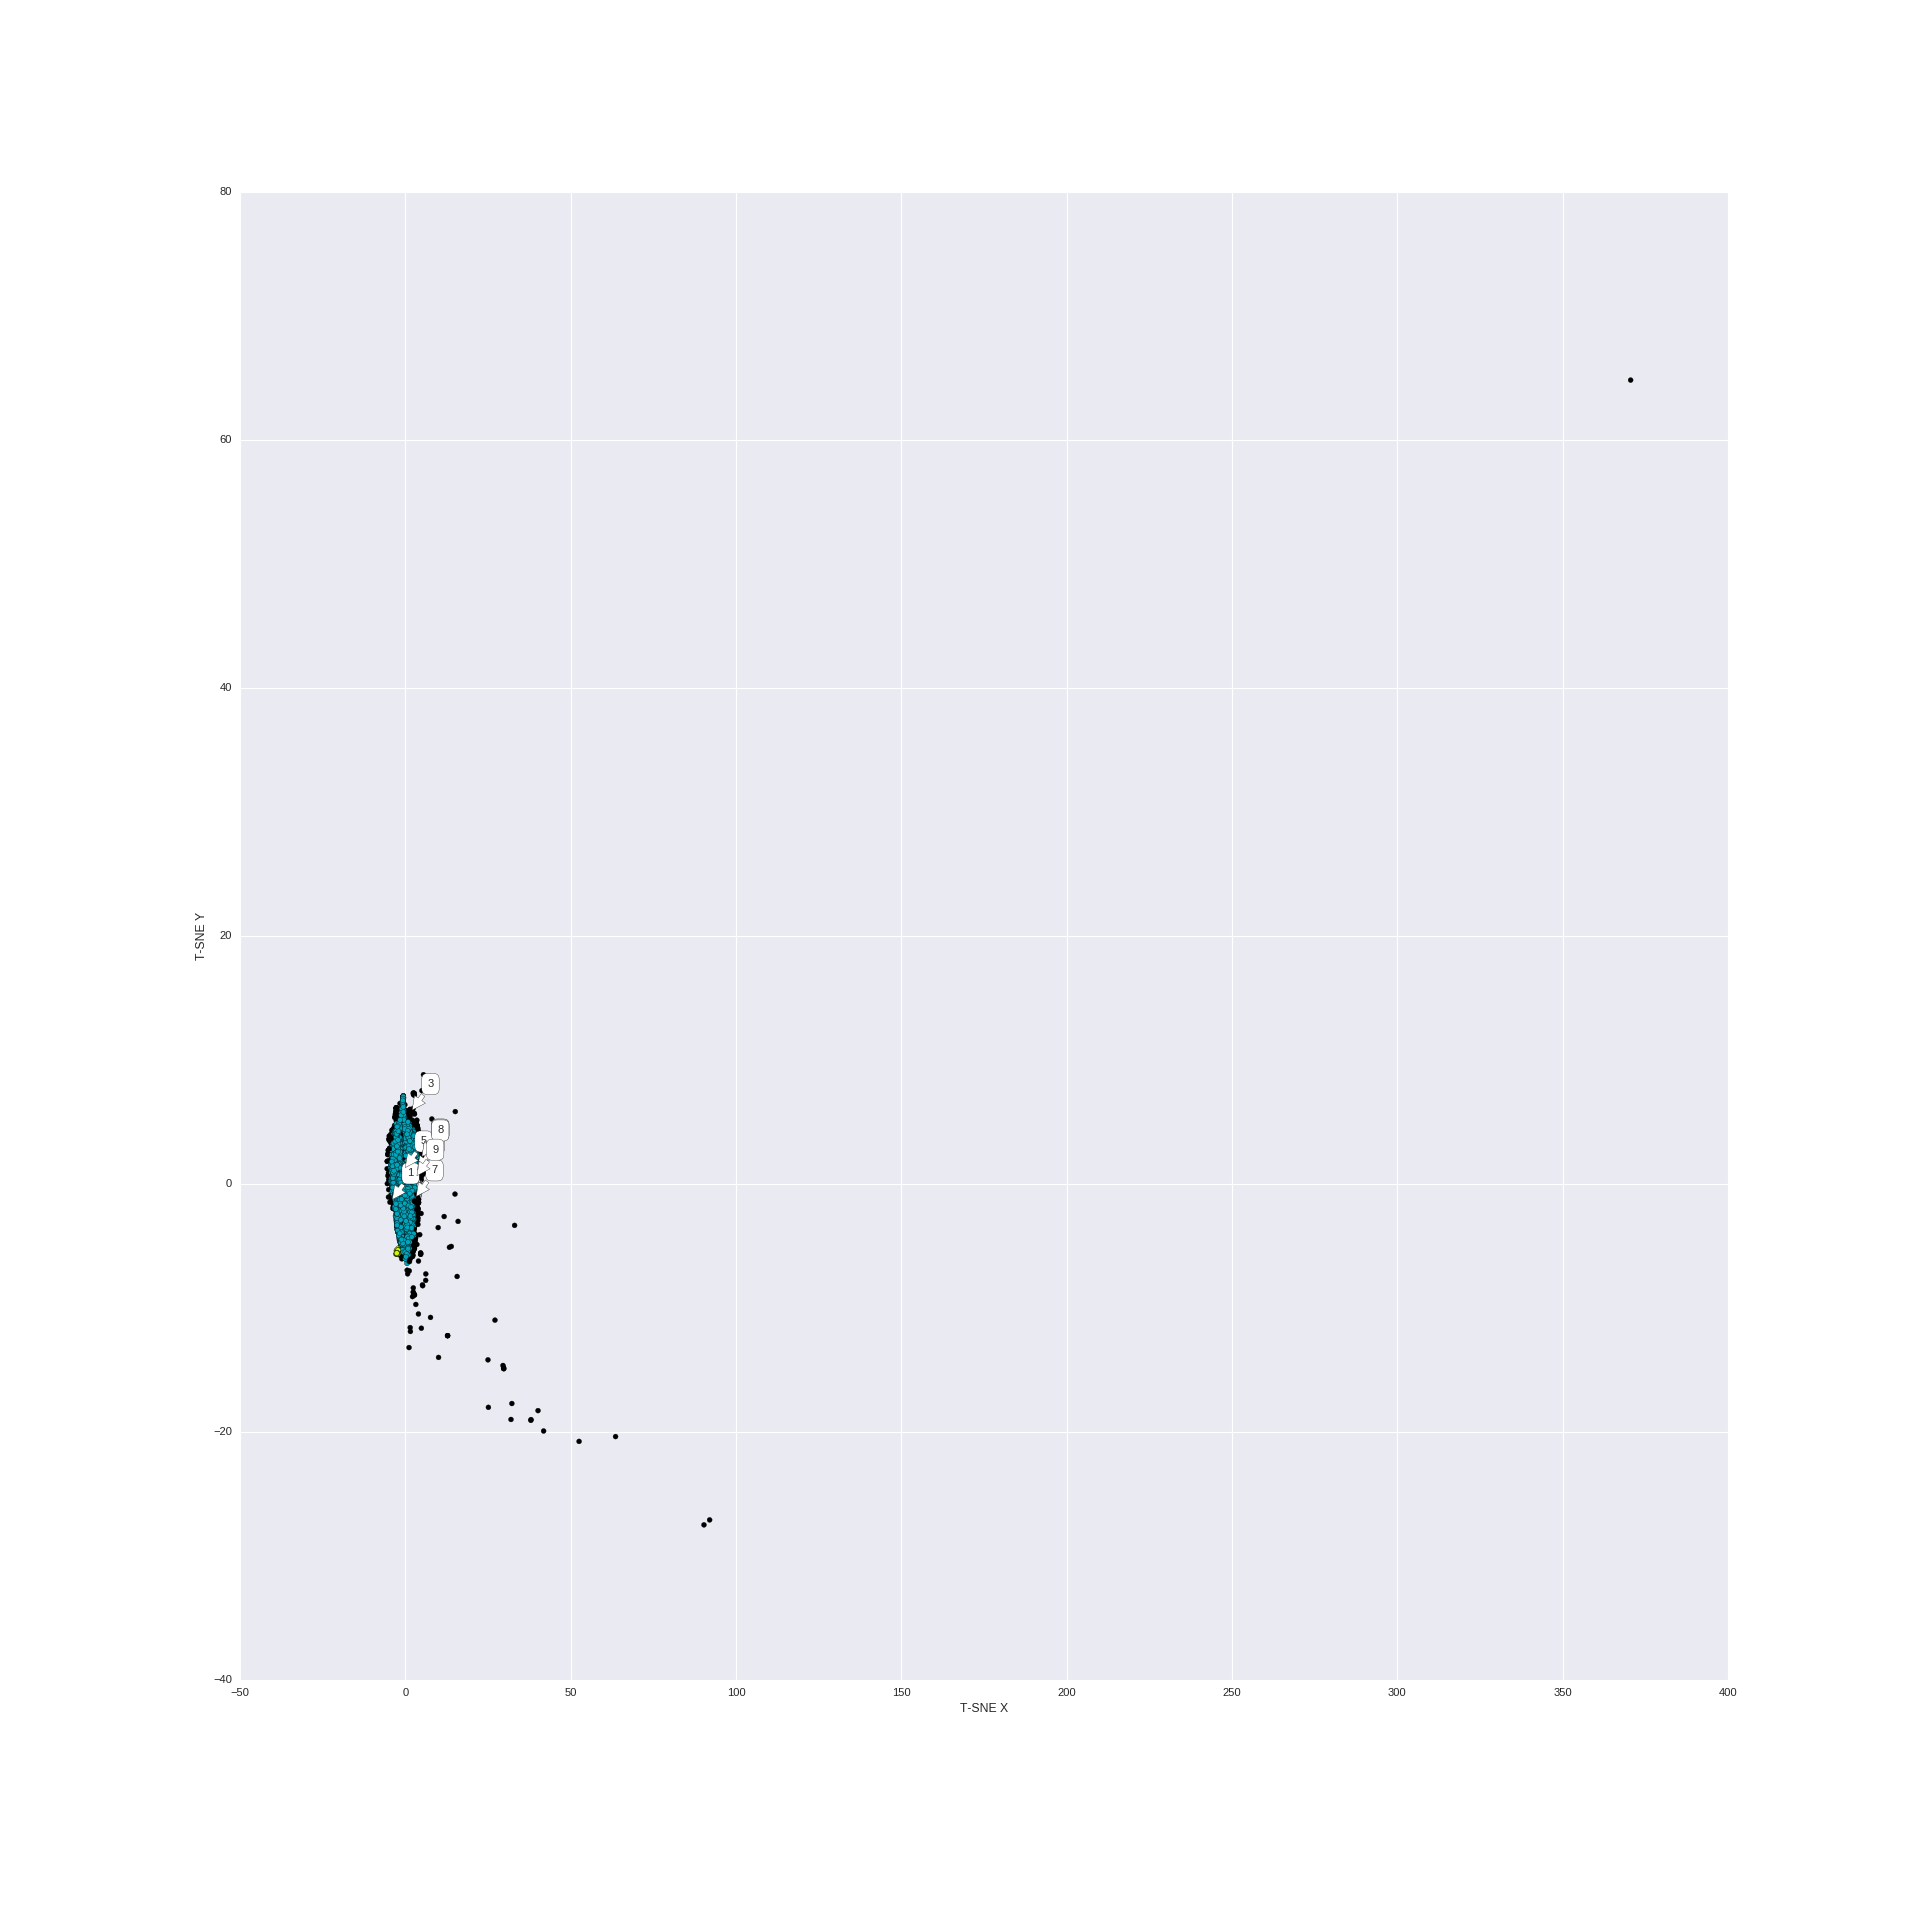

<IPython.core.display.Javascript object>


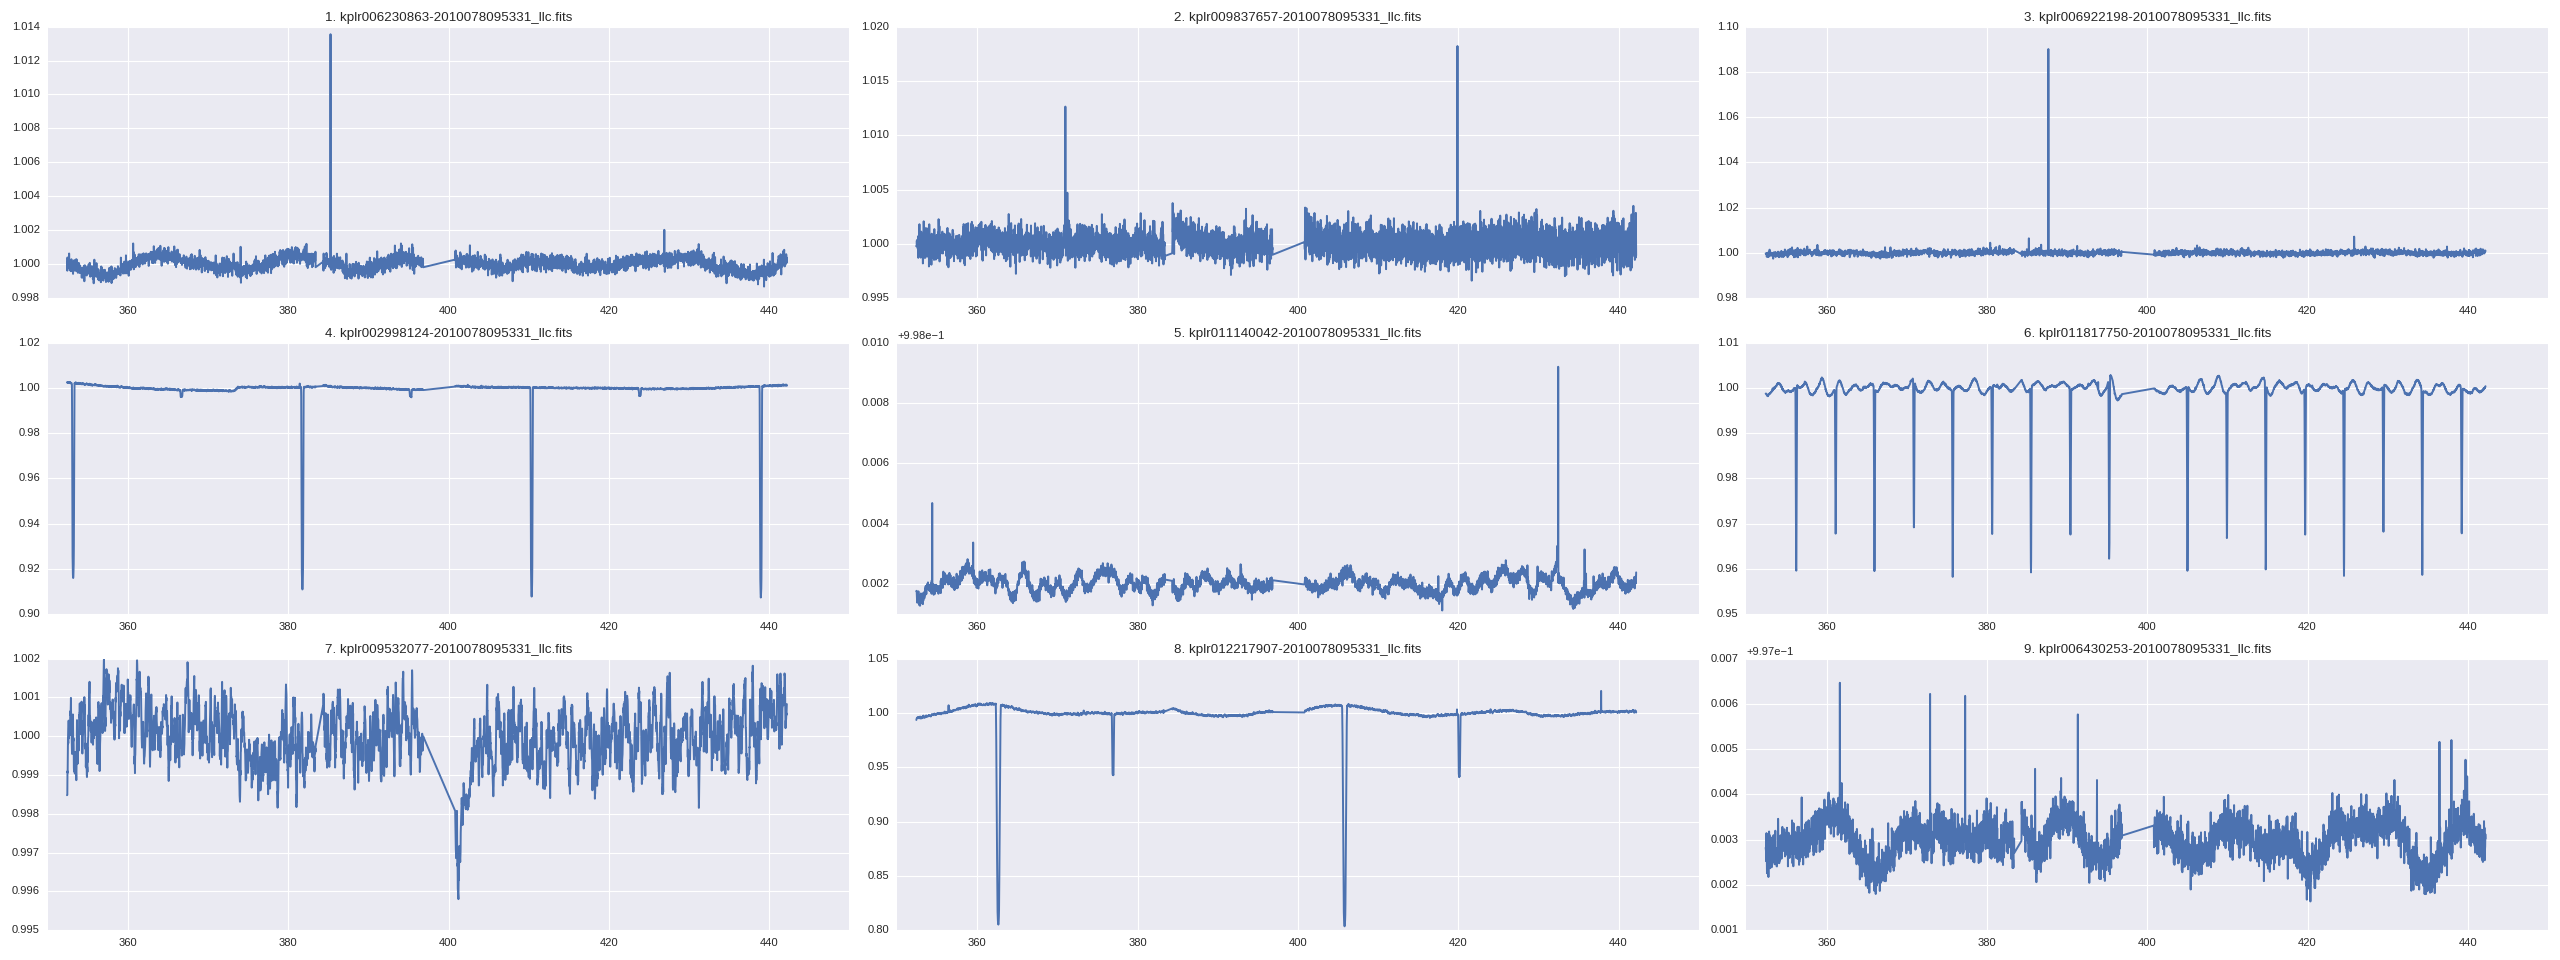

In [153]:

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.figure import Figure
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory
from numbapro import cuda

root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

def plotstuff(cluster):
    tarr=[]
    nfarr=[]
    
    for j in filesByCluster[cluster]:
        t,nf,err = read_kepler_curve(pathtofits+j)
        tarr.append(t)
        nfarr.append(nf)
    
    """--- Organizing data and Labels ---"""
    # empty subplots for lightcurves
    ax1 = plt.subplot(331)
    ax1.plot(tarr[randomInds[cluster][0]],nfarr[randomInds[cluster][0]])
    ax1.set_title('1. '+filesByCluster[cluster][randomInds[cluster][0]])
    ax2 = plt.subplot(332)
    ax2.plot(tarr[randomInds[cluster][1]],nfarr[randomInds[cluster][1]])
    ax2.set_title('2. '+filesByCluster[cluster][randomInds[cluster][1]])
    ax3 = plt.subplot(333)
    ax3.plot(tarr[randomInds[cluster][2]],nfarr[randomInds[cluster][2]])
    ax3.set_title('3. '+filesByCluster[cluster][randomInds[cluster][2]])
    ax4 = plt.subplot(334)
    ax4.plot(tarr[randomInds[cluster][3]],nfarr[randomInds[cluster][3]])
    ax4.set_title('4. '+filesByCluster[cluster][randomInds[cluster][3]])
    ax5 = plt.subplot(335)
    ax5.plot(tarr[randomInds[cluster][4]],nfarr[randomInds[cluster][4]])
    ax5.set_title('5. '+filesByCluster[cluster][randomInds[cluster][4]])
    ax6 = plt.subplot(336)
    ax6.plot(tarr[randomInds[cluster][5]],nfarr[randomInds[cluster][5]])
    ax6.set_title('6. '+filesByCluster[cluster][randomInds[cluster][5]])
    ax7 = plt.subplot(337)
    ax7.plot(tarr[randomInds[cluster][6]],nfarr[randomInds[cluster][6]])
    ax7.set_title('7. '+filesByCluster[cluster][randomInds[cluster][6]])
    ax8 = plt.subplot(338)
    ax8.plot(tarr[randomInds[cluster][7]],nfarr[randomInds[cluster][7]])
    ax8.set_title('8. '+filesByCluster[cluster][randomInds[cluster][7]])
    ax9 = plt.subplot(339)
    ax9.plot(tarr[randomInds[cluster][8]],nfarr[randomInds[cluster][8]])
    ax9.set_title('9. '+filesByCluster[cluster][randomInds[cluster][8]])
    
    plt.tight_layout()
    
if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = list(plotArray[0])
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    data = plotArray[2]
    # tsneX has all the x-coordinates
    tsneX = data[:,0]
    # tsneY has all the y-coordinates
    tsneY = data[:,1]
    
    filesByCluster = [[files[i] for i in range(len(clusterLabels)) \
                    if clusterLabels[i]==j] for j in range(-1,max(clusterLabels)+1)]
    
    randomInds = []
    for i in range(max(clusterLabels)+1):    
        if len(filesByCluster[i])>=9:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=False))
        else:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=True))
    cluster = 0
    plotIndices = []
    indDict = {}
    for i in range(9):
        fileInd = files.index(filesByCluster[cluster][randomInds[cluster][i]])
        plotIndices.append(fileInd)
        indDict[fileInd] = i+1
    """--- Organizing data and Labels ---"""
    # empty subplot for scattered data
    fig1 = plt.figure(1,figsize=(24, 24))
    ax = plt.subplot()
        
    def annotatePoint(XT, index,ind):
        x2, y2 = XT[index][0], XT[index][1]
        annotatePoint.label = ax.annotate( "%s" %ind,
            xy = (x2, y2), xytext = (20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 1),
            arrowprops = dict(facecolor='white',shrink=0.05,connectionstyle = 'arc3,rad=0.0'))
        
    def redraw():           
        # Set those labels
        ax.set_xlabel("T-SNE X")
        ax.set_ylabel("T-SNE Y")
        # Scatter the data
        ax.scatter(tsneX, tsneY,c=clusterLabels,cmap='nipy_spectral')
        
        for Index in plotIndices:
            annotatePoint(data, Index,indDict[Index])
        
    redraw() # First draw
    
    fig2 = plt.figure(2, figsize=(32, 12)) 
    plotstuff(0)
    plt.show()    

Choose the directory that the fits files are contained in.


<IPython.core.display.Javascript object>


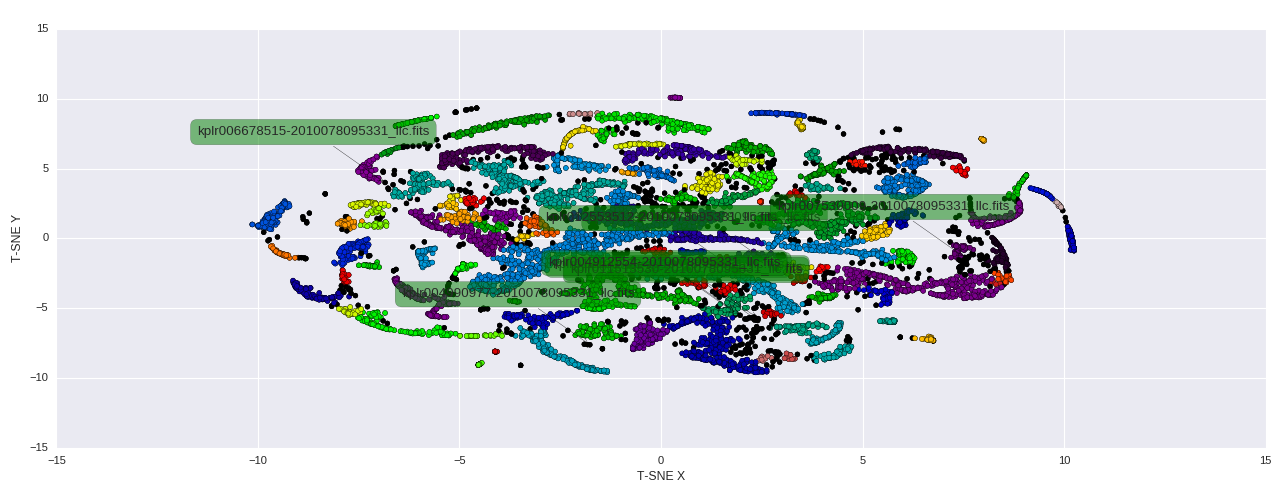

<IPython.core.display.Javascript object>


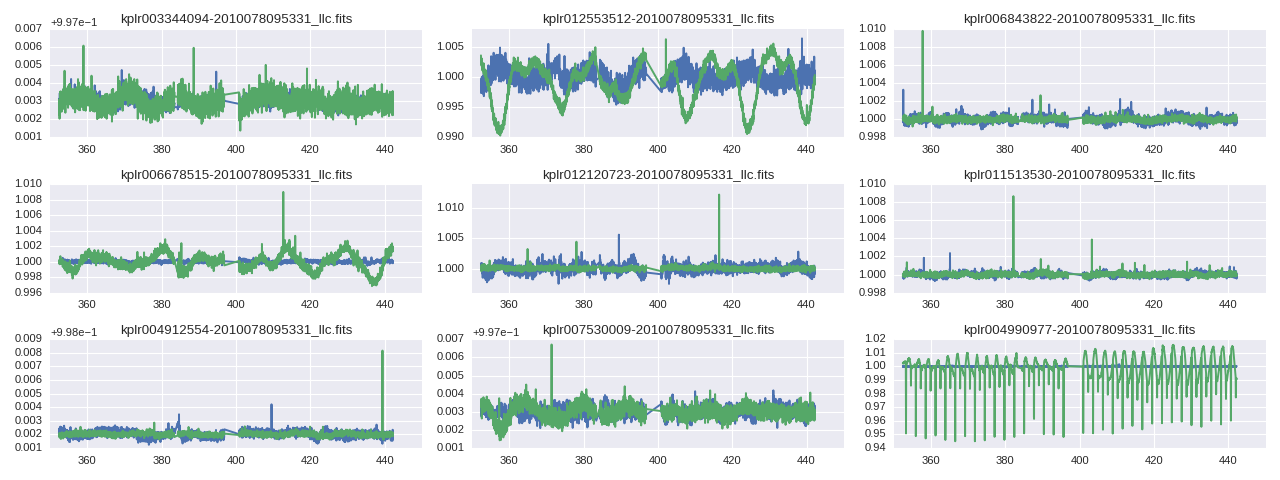

In [73]:
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory

root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

def plotstuff(cluster):
    tarr=[]
    nfarr=[]
    
    for j in filesByCluster[cluster]:
        t,nf,err = read_kepler_curve(pathtofits+j)
        tarr.append(t)
        nfarr.append(nf)
    
    """--- Organizing data and Labels ---"""
    # empty subplots for lightcurves
    ax1 = plt.subplot(331)
    ax1.plot(tarr[randomInds[cluster][0]],nfarr[randomInds[cluster][0]])
    ax1.set_title(filesByCluster[cluster][randomInds[cluster][0]])
    ax2 = plt.subplot(332)
    ax2.plot(tarr[randomInds[cluster][1]],nfarr[randomInds[cluster][1]])
    ax2.set_title(filesByCluster[cluster][randomInds[cluster][1]])
    ax3 = plt.subplot(333)
    ax3.plot(tarr[randomInds[cluster][2]],nfarr[randomInds[cluster][2]])
    ax3.set_title(filesByCluster[cluster][randomInds[cluster][2]])
    ax4 = plt.subplot(334)
    ax4.plot(tarr[randomInds[cluster][3]],nfarr[randomInds[cluster][3]])
    ax4.set_title(filesByCluster[cluster][randomInds[cluster][3]])
    ax5 = plt.subplot(335)
    ax5.plot(tarr[randomInds[cluster][4]],nfarr[randomInds[cluster][4]])
    ax5.set_title(filesByCluster[cluster][randomInds[cluster][4]])
    ax6 = plt.subplot(336)
    ax6.plot(tarr[randomInds[cluster][5]],nfarr[randomInds[cluster][5]])
    ax6.set_title(filesByCluster[cluster][randomInds[cluster][5]])
    ax7 = plt.subplot(337)
    ax7.plot(tarr[randomInds[cluster][6]],nfarr[randomInds[cluster][6]])
    ax7.set_title(filesByCluster[cluster][randomInds[cluster][6]])
    ax8 = plt.subplot(338)
    ax8.plot(tarr[randomInds[cluster][7]],nfarr[randomInds[cluster][7]])
    ax8.set_title(filesByCluster[cluster][randomInds[cluster][7]])
    ax9 = plt.subplot(339)
    ax9.plot(tarr[randomInds[cluster][8]],nfarr[randomInds[cluster][8]])
    ax9.set_title(filesByCluster[cluster][randomInds[cluster][8]])
    
    plt.tight_layout()
    
if __name__ == '__main__':
    """--- import light curve data ---"""
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    files = plotArray[0]
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    # data = plotArray[2]

    # dataByCluster = np.array([data[i] for i in range(max(clusterLabels)) if clusterLabels[i]==i])
    filesByCluster = [[files[i] \
                        for i in range(len(clusterLabels)) \
                    if clusterLabels[i]==j]\
                for j in range(-1,max(clusterLabels)+1)]
    randomInds = []
    for i in range(max(clusterLabels)+1):    
        if len(filesByCluster[i])>=9:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=False))
            # Returns array with 9 random indices
        else:
            randomInds.append(np.random.choice(range(len(filesByCluster[i])), 9, replace=True))
    fig1 = plt.figure(1, figsize=(16, 6)) 
    plt.title("Outlier Samples")
    plotstuff(0)
    fig2 = plt.figure(2, figsize=(16, 6))
    plt.title("Cluster 1 Samples")
    plotstuff(2)
    plt.show()